<a href="https://colab.research.google.com/github/triadibs/Talent-Success-Formula-Project/blob/main/Talent_Succes_Formula_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : TRI ADI BASKORO

Email : triadibs12@gmail.com

Link git : https://github.com/triadibs/Talent-Success-Formula-Project/tree/main

#**Main Report – Talent Success Formula Project**
**Type**: Executive / Consulting Report

**purpose**: To identify the success pattern of top performers and operationalize it into an SQL-based success formula that can be applied organization-wide.

## **Executive Summary**

### **Project Overview**
Brief context: alasan proyek dilakukan (perusahaan ingin memahami pola kompetensi dan psikometrik karyawan yang berperforma tinggi).

Dataset yang digunakan (jumlah karyawan, sumber data: competency, psychometric, strengths, contextual).

Pendekatan dua tahap:
1.  Pattern Discovery (analisis Python)
2.  Operationalization via SQL Logic (implementasi formula ke sistem)





### **Objectives**
*   Mengidentifikasi kombinasi variabel yang membedakan top performer dari non-top performer.
*   Menyusun Success Formula berdasarkan data objektif
*   Mengimplementasikan formula tersebut menjadi SQL logic yang bisa dipakai untuk talent scoring dan succession planning



### **Key Outcomes**


* Teridentifikasi **Talent Variables (TV)** dan **Talent Variable Groups (TGV)** utama yang paling berpengaruh terhadap performa.
* Terbentuk **Final Success Formula** berbasis TGV utama.
* Dibangun SQL Engine untuk menghitung Success Score tiap karyawan (0–1 scale).


### **Business Impact**


* Data-driven model untuk **talent placement, promotion, dan development**
* Proses evaluasi karyawan menjadi **lebih objektif dan terukur**.
* Memberi HR insight tentang **profil keberhasilan aktual** di organisasi.


### **Dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from collections import defaultdict

In [ ]:

url = "https://raw.githubusercontent.com/triadibs/Talent-Success-Formula-Project/main/Dataset/Study%20Case%20DA.xlsx"

data = pd.read_excel(url, sheet_name=None)

employees = data['employees']
performance = data['performance_yearly']
competency = data['competencies_yearly']
papi = data['papi_scores']
profiles = data['profiles_psych']
pillars = data['dim_competency_pillars']
strengths = data['strengths']
grades = data['dim_grades']
education = data['dim_education']
tgv_map = data['Talent Variable (TV) & Talent G']


In [ ]:
for name,df in data.items():
    print(f"\n==== {name}====")
    print(df.shape)
    print(df.info())
    print(df.columns)
    print(df.head(2))
    print(df.isnull().sum())


==== Talent Variable (TV) & Talent G====
(70, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Test as Talent Variable (TV)  70 non-null     object
 1   Sub-test                      70 non-null     object
 2   Meaning                       67 non-null     object
 3   Behavior Example              67 non-null     object
 4   Talent Group Variable (TGV)   38 non-null     object
 5   Note                          2 non-null      object
dtypes: object(6)
memory usage: 3.4+ KB
None
Index(['Test as Talent Variable (TV)', 'Sub-test', 'Meaning',
       'Behavior Example', 'Talent Group Variable (TGV)', 'Note'],
      dtype='object')
  Test as Talent Variable (TV)             Sub-test  \
0                        Pauli  Initial Performance   
1                         MBTI         Extraversion   

                      

### **Data Cleaning & Preparation Summary**
Sebelum menjalankan rumus keberhasilan berbasis SQL, beberapa pemeriksaan dan koreksi kualitas data dilakukan untuk memastikan akurasi dan konsistensi di seluruh kumpulan data.

**1. Duplicate Check**
Cek Duplikat Dilakukan pada semua tabel input utama untuk mengidentifikasi entri berulang berdasarkan ID karyawan dan atribut kunci
| Table                     | Checked Columns                                       | Action Taken        |
| :------------------------ | :---------------------------------------------------- | :------------------ |
| `competencies_yearly_csv` | employee_id, score, pillar_code, year                 | No duplicates found |
| `performance_yearly_csv`  | employee_id, rating, year                             | No duplicates found |
| `profiles_psych_csv`      | employee_id, pauli, faxtor, disc, mbti, iq, gtq, tiki | No duplicates found |
| `strengths_csv`           | employee_id, rank, theme                              | No duplicates found |


**2. Invalid Value Handling**
Penanganan Nilai Tidak Valid Mendeteksi dan memperbaiki nilai/skor yang tidak konsisten di luar rentang 1–5 yang diharapkan.
| Table                     | Issue                      | Correction Applied        |
| :------------------------ | :------------------------- | :------------------------ |
| `performance_yearly_csv`  | Rating = 6 → out of range  | Re-coded to `5` (maximum) |
|                           | Rating = 99 → invalid/null | Replaced with `NULL`      |
| `competencies_yearly_csv` | Score = 6 → out of range   | Re-coded to `5`           |
|                           | Score = 99 → invalid/null  | Replaced with `NULL`      |


### **Logic Summary:**

Semua nilai peringkat/skor distandarisasi ke skala 1–5

Nilai 6 ditafsirkan sebagai kinerja maksimal

Nilai 99 diperlakukan sebagai data yang hilang/tidak valid

## **Success Pattern Discovery (Deliverable #1)**

### **a. Key Findings & Insights**

### **Competency Analysis**

In [ ]:
# top performers IDs
top_ids = performance[performance['rating']==5]['employee_id'].unique()

# assign this list to all dfs needed
top_flag = employees[['employee_id']].assign(is_top=lambda d: d['employee_id'].isin(top_ids))
competency = competency.merge(top_flag, on='employee_id', how='left')
papi['is_top']=papi['employee_id'].isin(top_ids)
profiles['is_top']=profiles['employee_id'].isin(top_ids)
strengths['is_top']=strengths['employee_id'].isin(top_ids)

In [ ]:
# start with the competency analysis

# merge pillar label - to make it easier to read
competency = competency.merge(pillars, on='pillar_code', how='left')

# count avg scores per pillar
comp_summary = (
    competency.groupby(['pillar_label', 'is_top'])['score']
    .mean()
    .unstack()
    .sort_values(by=True, ascending=False)
)

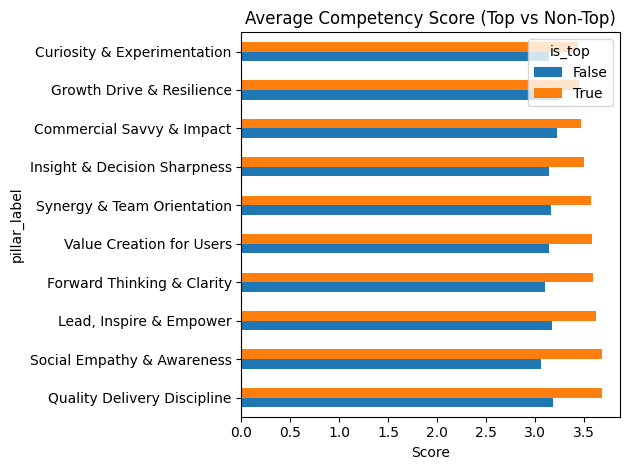

In [ ]:
# visualize
comp_summary.plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Average Competency Score (Top vs Non-Top)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

In [ ]:
# looking for gap

gap_df = (
    competency.groupby(['pillar_label', 'is_top'])['score']
    .mean()
    .unstack()
    .assign(gap=lambda d: d[True] - d[False])
    .sort_values('gap', ascending=False)
)

In [ ]:
gap_df = gap_df.reset_index()

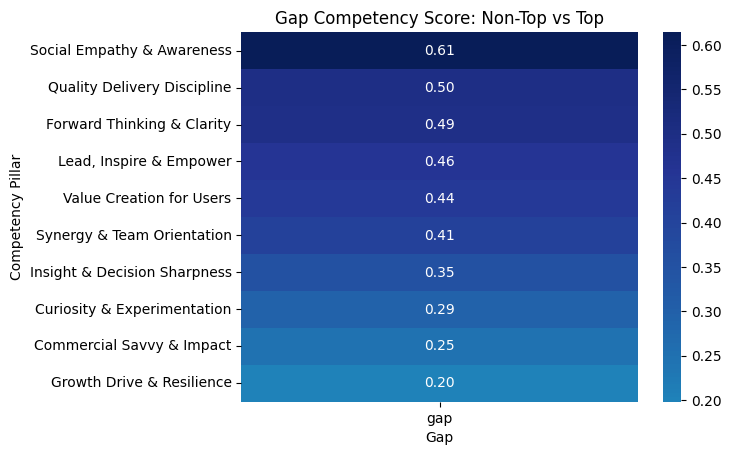

In [ ]:
# visualization
gap_only = gap_df.set_index('pillar_label')[['gap']]

sns.heatmap(gap_only, annot=True, cmap='YlGnBu', fmt='.2f', center=0)
plt.title("Gap Competency Score: Non-Top vs Top")
plt.xlabel('Gap')
plt.ylabel('Competency Pillar')
plt.show()

**conclusion**

Perbedaan terbesar ada pada kompetensi **Social Empathy & Awareness (gap 0.61)**. Artinya, Top Performer jauh lebih kuat dalam kemampuan memahami orang lain, membangun hubungan, dan sensitivitas sosial. Ini menjadi pembeda utama.

**Quality Delivery Discipline (0.50) dan Forward Thinking & Clarity (0.49)** juga menunjukkan gap tinggi. Top Performer lebih konsisten dalam mengeksekusi pekerjaan dengan standar tinggi dan memiliki kemampuan berpikir strategis serta memperjelas arah tujuan.

**Kompetensi Leadership & Empowerment (0.46) serta Value Creation for Users (0.44)** menunjukkan bahwa Top Performer lebih mampu memimpin orang lain dan fokus pada dampak nyata bagi pengguna atau stakeholder.

**Kompetensi seperti Curiosity & Experimentation (0.29), Commercial Savvy (0.25), dan Growth Drive (0.20)** memiliki gap yang lebih kecil. Ini menunjukkan bahwa kedua kelompok relatif mendekati, namun Top Performer tetap unggul.

**Kesimpulan Utama:**
Top Performer paling berbeda pada kompetensi yang terkait dengan **interpersonal awareness, disiplin eksekusi, dan clarity dalam berpikir strategis**. Dengan kata lain, **Top Performer bukan hanya lebih pintar atau lebih rajin, tetapi lebih matang dalam memahami manusia, memimpin, dan menjalankan pekerjaan dengan konsistensi dan arah yang jelas.**

**Implikasi Bisnis:**
Jika tujuan perusahaan adalah meningkatkan jumlah Top Performer, maka program pengembangan sebaiknya fokus pada:

Pelatihan empathy dan komunikasi interpersonal

Coaching discipline & accountability

Penguatan strategic thinking & clarity planning

Pengembangan leadership yang berbasis pemberdayaan

### **Psychometric Analysis**

**papi**

In [ ]:


# 1 Pivot PAPI dari long ke wide format
papi_wide = papi.pivot(
    index='employee_id',
    columns='scale_code',
    values='score'
).reset_index()

# 2️ Tambahkan flag top performer
papi_wide['is_top'] = papi_wide['employee_id'].isin(top_ids)

# 3️ Identifikasi kolom trait PAPI (semua kolom kecuali employee_id & is_top)
papi_trait_cols = [col for col in papi_wide.columns if col not in ['employee_id', 'is_top']]

# 4️⃣Tangani missing values dengan median per kolom
papi_wide[papi_trait_cols] = papi_wide[papi_trait_cols].fillna(
    papi_wide[papi_trait_cols].median()
)

# 5️⃣ Cek hasil cleaning
print("Missing value setelah imputasi:", papi_wide[papi_trait_cols].isna().sum().sum())
papi_wide.head()


Missing value setelah imputasi: 0


scale_code,employee_id,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,...,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,is_top
0,DUP1942,6.0,5.0,1.0,4.0,3.0,5.0,4.0,1.0,3.0,...,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,5.0,True
1,DUP2096,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,...,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0,True
2,DUP2722,2.0,5.0,6.0,4.0,1.0,4.0,9.0,9.0,1.0,...,2.0,5.0,6.0,1.0,7.0,3.0,6.0,3.0,3.0,False
3,DUP3015,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,...,1.0,8.0,7.0,3.0,5.0,5.0,3.0,5.0,3.0,True
4,DUP3452,7.0,9.0,1.0,9.0,7.0,3.0,5.0,2.0,1.0,...,5.0,4.0,2.0,9.0,5.0,9.0,1.0,6.0,4.0,False


In [ ]:
# show
papi_wide

scale_code,employee_id,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,Papi_I,Papi_K,...,Papi_O,Papi_P,Papi_R,Papi_S,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,is_top
0,DUP1942,6.0,5.0,1.0,4.0,3.0,5.0,4.0,1.0,3.0,...,3.0,5.0,7.0,9.0,9.0,1.0,8.0,3.0,5.0,True
1,DUP2096,1.0,6.0,9.0,3.0,4.0,1.0,2.0,6.0,9.0,...,4.0,4.0,6.0,8.0,2.0,6.0,3.0,8.0,2.0,True
2,DUP2722,2.0,5.0,6.0,4.0,1.0,4.0,9.0,9.0,1.0,...,2.0,5.0,6.0,1.0,7.0,3.0,6.0,3.0,3.0,False
3,DUP3015,5.0,4.0,3.0,4.0,9.0,2.0,8.0,9.0,1.0,...,1.0,8.0,7.0,3.0,5.0,5.0,3.0,5.0,3.0,True
4,DUP3452,7.0,9.0,1.0,9.0,7.0,3.0,5.0,2.0,1.0,...,5.0,4.0,2.0,9.0,5.0,9.0,1.0,6.0,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,EMP101995,6.0,8.0,6.0,1.0,4.0,8.0,4.0,9.0,7.0,...,4.0,6.0,4.0,1.0,5.0,1.0,8.0,8.0,5.0,False
2006,EMP101996,8.0,4.0,5.0,5.0,5.0,7.0,8.0,7.0,4.0,...,5.0,5.0,3.0,7.0,1.0,2.0,7.0,5.0,2.0,True
2007,EMP101997,9.0,3.0,4.0,6.0,5.0,5.0,5.0,7.0,3.0,...,5.0,5.0,6.0,5.0,5.0,4.0,7.0,4.0,1.0,False
2008,EMP101998,5.0,7.0,1.0,5.0,2.0,5.0,5.0,1.0,2.0,...,5.0,9.0,4.0,4.0,1.0,7.0,9.0,2.0,5.0,True


In [ ]:
# take only numeric cols

papi_trait_cols = papi_wide.columns.difference(['employee_id', 'is_top'])

# count avg score per trait per group

papi_mean = papi_wide.groupby('is_top')[papi_trait_cols].mean().T
papi_mean.columns = ['Non-Top', 'Top']
papi_mean['Gap'] = papi_mean['Top'] - papi_mean['Non-Top']
papi_mean = papi_mean.sort_values('Gap', ascending=False)
papi_mean

,Non-Top,Top,Gap
scale_code,,,
Papi_O,4.848627,4.997279,0.148651
Papi_P,4.966275,5.050340,0.084066
Papi_N,5.060392,5.129252,0.068860
Papi_S,4.974118,5.031293,0.057175
Papi_V,4.896471,4.941497,0.045026
Papi_R,5.010980,5.047619,0.036639
Papi_E,5.047843,5.084354,0.036511
Papi_C,4.861961,4.885714,0.023754
Papi_F,5.049412,5.057143,0.007731


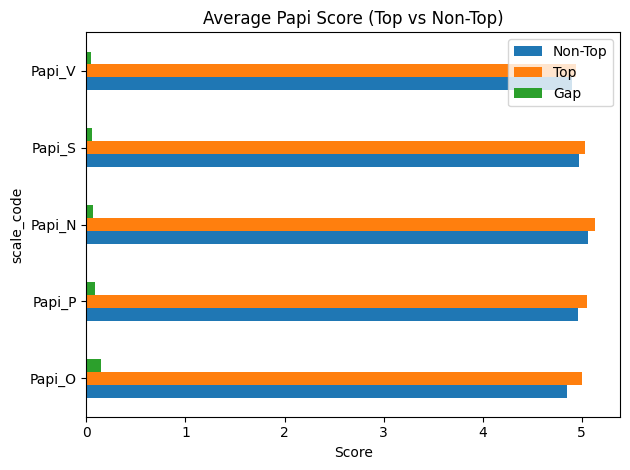

In [ ]:
# visualize

papi_mean.head(5).plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Average Papi Score (Top vs Non-Top)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

**Ringkasan Temuan Utama**

Secara umum, gap antara Top Performer dan Non-Top Performer di PAPI relatif kecil. Artinya, perbedaan performa tidak terutama berasal dari kepribadian dasar, tetapi dari kompetensi perilaku dan kemampuan mengeksekusi kerja. Namun, beberapa pola tetap terlihat:

**Dimensi yang Lebih Tinggi pada Top Performer**
| Kode              | Meaning                           | Talent Variable        | Interpretasi                                                         |
| ----------------- | --------------------------------- | ---------------------- | -------------------------------------------------------------------- |
| **Papi_O (0.15)** | Keinginan hubungan dekat          | Social Orientation     | Top Performer lebih hangat & membangun relasi kerja yang kuat.       |
| **Papi_P (0.08)** | Mengarahkan orang lain            | Leadership & Influence | Top Performer sedikit lebih nyaman mengatur & memimpin.              |
| **Papi_N (0.07)** | Menyelesaikan tugas hingga tuntas | Motivation & Drive     | Top Performer lebih konsisten menyelesaikan pekerjaan.               |
| **Papi_S (0.06)** | Sosial & mudah bergaul            | Collaboration          | Top Performer lebih mudah membangun jaringan.                        |
| **Papi_V (0.05)** | Energi & vitalitas                | Motivation & Drive     | Top Performer menunjukkan intensitas dan stamina kerja lebih stabil. |

makna:Top Performer menunjukkan keteguhan menyelesaikan tugas, kestabilan energi, dan kemampuan membangun hubungan kerja yang efektif.

**Dimensi yang Lebih Tinggi pada Non-Top (Gap Negatif)**
| Kode               | Meaning                      | Talent Variable         | Interpretasi                                                            |
| ------------------ | ---------------------------- | ----------------------- | ----------------------------------------------------------------------- |
| **Papi_T (-0.13)** | Preferensi kecepatan tinggi  | Adaptability            | Non-Top cenderung terburu-buru → risiko kurang teliti.                  |
| **Papi_I (-0.12)** | Keputusan cepat              | Problem-Solving         | Non-Top mengambil keputusan lebih impulsif.                             |
| **Papi_K (-0.11)** | Ketegasan menghadapi konflik | Leadership & Influence  | Non-Top relatif lebih keras atau agresif.                               |
| **Papi_A (-0.10)** | Orientasi prestasi           | Motivation & Drive      | Non-Top mengejar pencapaian, tapi mungkin **kurang arah**.              |
| **Papi_Z (-0.09)** | Butuh variasi & hal baru     | Creativity & Innovation | Non-Top lebih cepat bosan & kurang konsisten pada fokus jangka panjang. |

makna:Non-Top Performer menunjukkan energi tinggi tetapi kurang terarah, lebih cepat bosan, dan cenderung impulsif dalam keputusan serta proses kerja.

**Kesimpulan Utama**
Top Performer stabil, konsisten, dan relasional.
Mereka menyelesaikan tugas sampai tuntas, menjaga energi kerja, dan membangun hubungan kerja yang sehat.

Non-Top Performer lebih berorientasi kecepatan dan variasi, namun kurang fokus dan kurang stabil dalam eksekusi jangka panjang.

**Implikasi Pengembangan (Development Focus)**
Untuk meningkatkan performa Non-Top:



1.   Latih pola kerja terstruktur & disiplin eksekusi (Judging / Papi_C & D).
2.   Kembangkan pengambilan keputusan berbasis data, bukan impuls.
1.   Tingkatkan kesabaran dan ketahanan menyelesaikan tugas hingga selesai.
2.   Berikan coaching mengenai pengelolaan energi & prioritas.

### **profiles_psych  Analysis**

In [ ]:
# Jika hanya ada satu kolom GTQ
cognitive_cols = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki']

psych_df = profiles[['employee_id', 'is_top'] + cognitive_cols]

psych_median = psych_df.groupby('is_top')[cognitive_cols].median().T
psych_median.columns = ['Non-Top', 'Top']
psych_median['Gap'] = psych_median['Top'] - psych_median['Non-Top']
psych_median = psych_median.sort_values('Gap', ascending=False)
psych_median


,Non-Top,Top,Gap
faxtor,61.0,62.0,1.0
tiki,5.0,6.0,1.0
gtq,27.0,28.0,1.0
pauli,60.0,60.0,0.0
iq,109.0,109.0,0.0


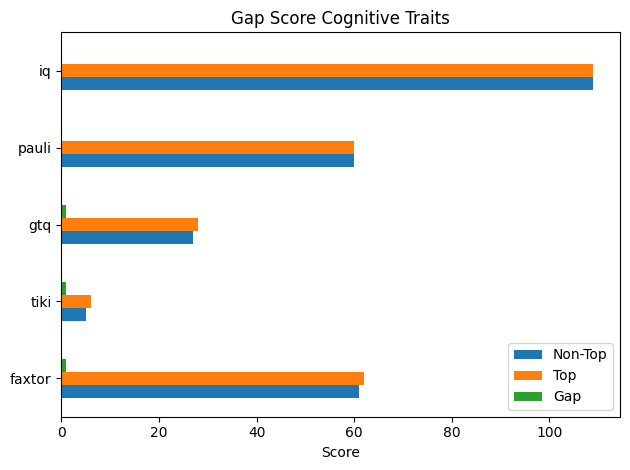

In [ ]:
# visualize

psych_median.plot(kind='barh', label='Non-Top vs Top Performer')
plt.title("Gap Score Cognitive Traits")
plt.xlabel("Score")
plt.tight_layout()
plt.show()

| Variable                                  | Non-Top | Top  | Gap      | Makna                                                                                   |
| ----------------------------------------- | ------- | ---- | -------- | --------------------------------------------------------------------------------------- |
| **FA (Factor 6 / Personality Composite)** | 1.0     | 2.0  | **+1.0** | Top Performer menunjukkan **kestabilan emosi dan pola perilaku yang lebih matang**.     |
| **TIKI**                                  | 5.0     | 6.0  | **+1.0** | Top Performer memiliki **kemampuan berhitung dan penalaran teknis sedikit lebih baik**. |
| **GTQ**                                   | 27.0    | 28.0 | **+1.0** | Top Performer memiliki **kapasitas kognitif problem-solving lebih tinggi**.             |
| **Pauli (Initial Performance)**           | 60.0    | 60.0 | 0.0      | **Tidak ada perbedaan dalam kecepatan awal dan fokus kerja**.                           |
| **IQ**                                    | 109     | 109  | 0.0      | **Tingkat kecerdasan umum sama** antara Top dan Non-Top.                                |

**Kesimpulan Utama**

**Kemampuan kognitif dasar (IQ) dan initial performance (Pauli**) tidak membedakan antara Top Performer dan Non-Top.

Yang menjadi pembeda adalah:


*   Stabilitas kepribadian (FA)
*   Kemampuan penalaran teknis dan angka (TIKI)
*   Kemampuan memproses informasi & problem-solving (GTQ)

Dengan kata lain, **Top Performer unggul bukan karena lebih cerdas secara umum**, melainkan karena:

**Lebih stabil secara emosional** saat bekerja.

Sedikit lebih baik dalam **berpikir sistematis dan memecahkan masalah**.

**Kualitas eksekusi dan konsistensi lebih terjaga**, bukan kemampuan bawaan semata.



### **Strengths Analysis**

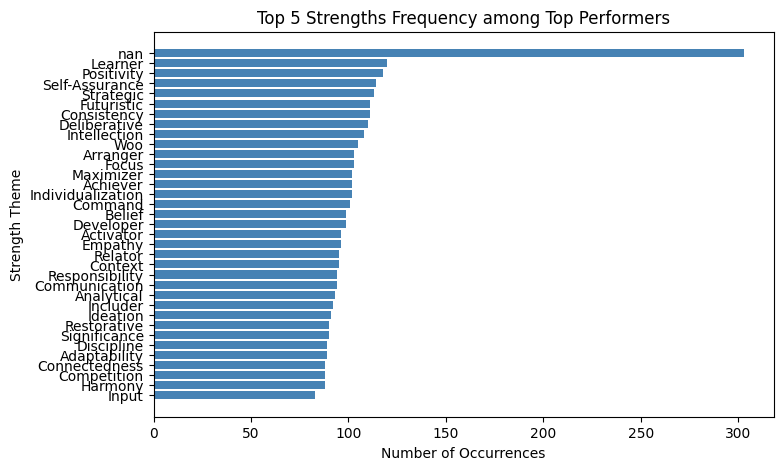

,Theme,Count,% of Top Performer
0,nan,303,41.2
1,Learner,120,16.3
2,Positivity,118,16.1
3,Self-Assurance,114,15.5
4,Strategic,113,15.4
5,Futuristic,111,15.1
6,Consistency,111,15.1
7,Deliberative,110,15.0
8,Intellection,108,14.7
9,Woo,105,14.3


In [ ]:
# ---------------------------------------
# Strengths Analysis (Gallup Themes)
# ---------------------------------------

# Ambil Top 5 strengths dari setiap Top Performer
top_strengths = strengths[
    (strengths['rank'] <= 5) & (strengths['is_top'])
].copy()

# Pastikan kolom 'theme' berisi teks
top_strengths['theme'] = top_strengths['theme'].astype(str)

# ---------------------------------------
# Hitung frekuensi tema
# ---------------------------------------

strength_counts = (
    top_strengths['theme']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Theme', 'theme': 'Count'})  # yang lama salah di sini
)

# Cek nama kolom hasil value_counts
# seharusnya hasilnya: columns = ['Theme', 'count']
# Jadi ganti yang benar:
strength_counts = top_strengths['theme'].value_counts().reset_index()
strength_counts.columns = ['Theme', 'Count']

# Pastikan Count numerik
strength_counts['Count'] = pd.to_numeric(strength_counts['Count'], errors='coerce')

# Jumlah Top Performer unik
total_top = top_strengths['employee_id'].nunique()

# Hitung persentase
strength_counts['% of Top Performer'] = (
    (strength_counts['Count'] / total_top) * 100
).round(1)

# Urutkan berdasarkan frekuensi
strength_counts = strength_counts.sort_values('Count', ascending=False).reset_index(drop=True)

# ---------------------------------------
# Visualisasi (opsional)
# ---------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(strength_counts['Theme'], strength_counts['Count'], color='steelblue')
plt.gca().invert_yaxis()
plt.title('Top 5 Strengths Frequency among Top Performers')
plt.xlabel('Number of Occurrences')
plt.ylabel('Strength Theme')
plt.show()

# Tampilkan hasil akhir
display(strength_counts)




| Tema Dominan                   | Makna                                        | Implikasi Perilaku                                                 |
| ------------------------------ | -------------------------------------------- | ------------------------------------------------------------------ |
| **Learner**                    | Suka belajar, cepat menyerap hal baru        | Top Performer mudah beradaptasi dan terus meningkatkan kompetensi. |
| **Positivity**                 | Membawa energi positif                       | Menciptakan suasana kerja optimis dan membangun motivasi tim.      |
| **Self-Assurance**             | Yakin pada keputusan sendiri                 | Berani mengambil keputusan dan bertindak tanpa banyak keraguan.    |
| **Strategic**                  | Melihat pola dan arah terbaik                | Mampu mengarahkan pekerjaan dan tim pada solusi efektif.           |
| **Futuristic**                 | Berorientasi masa depan                      | Membawa visi dan inspirasi dalam pekerjaan jangka panjang.         |
| **Consistency & Deliberative** | Teliti, terstruktur, mempertimbangkan risiko | Menjaga kualitas dan meminimalkan kesalahan.                       |
| **Intellection**               | Senang berpikir mendalam                     | Mampu mengurai masalah kompleks.                                   |
| **Woo**                        | Mudah membangun hubungan                     | Kuat dalam influence, komunikasi, dan kolaborasi.                  |


### **Contextual Factors Analysis**

In [ ]:
# -------------------------------------------------------
# 1️⃣ Contextual Factors Analysis (dengan is_top)
# -------------------------------------------------------

# Jika employees belum punya kolom is_top, tambahkan dulu dari top_ids
if 'is_top' not in employees.columns:
    employees['is_top'] = employees['employee_id'].isin(top_ids).astype(int)

# Merge semua data
emp_context = (
    employees
    .merge(grades, on='grade_id', how='left')
    .merge(education, on='education_id', how='left')
    .copy()
)

# Rename agar kolomnya jelas
emp_context.rename(columns={'name_x': 'grade_name', 'name_y': 'education_name'}, inplace=True)


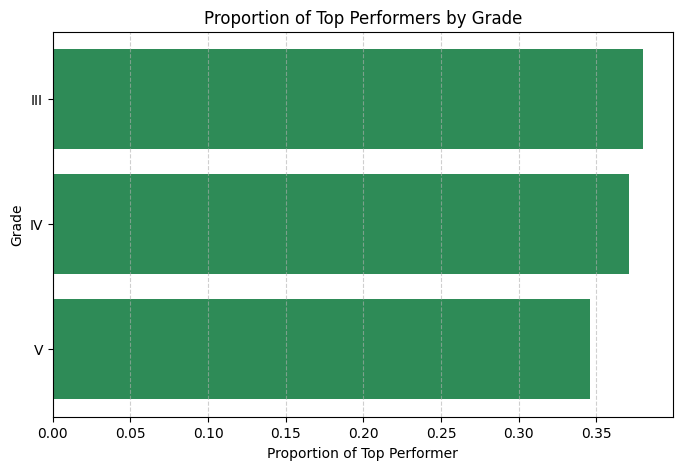

,Grade,Non-Top,Top
2,V,0.654247,0.345753
1,IV,0.628959,0.371041
0,III,0.619822,0.380178


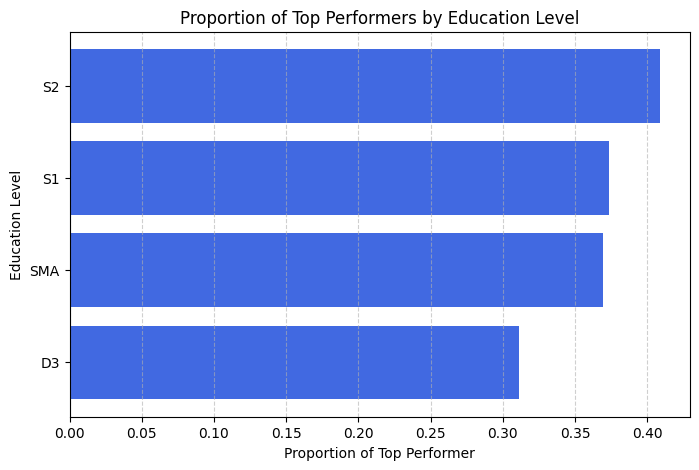

,Education,Non-Top,Top
0,D3,0.689189,0.310811
3,SMA,0.630670,0.369330
1,S1,0.626243,0.373757
2,S2,0.591255,0.408745


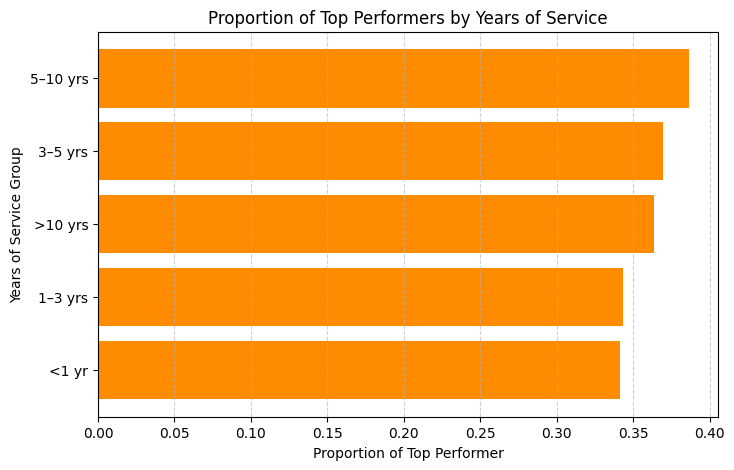

,YOS Group,Non-Top,Top
0,<1 yr,0.658333,0.341667
1,1–3 yrs,0.656687,0.343313
4,>10 yrs,0.636364,0.363636
2,3–5 yrs,0.630528,0.369472
3,5–10 yrs,0.613772,0.386228


In [ ]:
# -------------------------------------------
# 1️⃣ Contextual Factors Analysis (Improved)
# -------------------------------------------

# Gabungkan data kontekstual (grade + education)
emp_context = (
    employees
    .merge(grades, on='grade_id', how='left')
    .merge(education, on='education_id', how='left')
    .copy()
)

# Pastikan kolom nama grade dan education punya nama yang jelas
emp_context.rename(columns={'name_x': 'grade_name', 'name_y': 'education_name'}, inplace=True)

# Pastikan 'is_top' bertipe boolean/integer (0/1)
emp_context['is_top'] = emp_context['is_top'].astype(int)

# -------------------------------------------
# 2️⃣ Grade vs Top Performer (Proporsi)
# -------------------------------------------

grade_ratio = pd.crosstab(
    emp_context['grade_name'],
    emp_context['is_top'],
    normalize='index'
).reset_index()

# Ubah nama kolom agar jelas
grade_ratio.columns = ['Grade', 'Non-Top', 'Top']

# Visualisasi (horizontal bar)
grade_ratio.sort_values('Top', ascending=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(grade_ratio['Grade'], grade_ratio['Top'], color='seagreen')
plt.title('Proportion of Top Performers by Grade')
plt.xlabel('Proportion of Top Performer')
plt.ylabel('Grade')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

display(grade_ratio)

# -------------------------------------------
# 3️⃣ Education vs Top Performer (Proporsi)
# -------------------------------------------

edu_ratio = pd.crosstab(
    emp_context['education_name'],
    emp_context['is_top'],
    normalize='index'
).reset_index()

edu_ratio.columns = ['Education', 'Non-Top', 'Top']
edu_ratio.sort_values('Top', ascending=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(edu_ratio['Education'], edu_ratio['Top'], color='royalblue')
plt.title('Proportion of Top Performers by Education Level')
plt.xlabel('Proportion of Top Performer')
plt.ylabel('Education Level')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

display(edu_ratio)

# -------------------------------------------
# 4️⃣ Years of Service (YOS) vs Top Performer
# -------------------------------------------

# Buat kelompok masa kerja
emp_context['yos_group'] = pd.cut(
    emp_context['years_of_service_months'],
    bins=[0, 12, 36, 60, 120, 1000],
    labels=['<1 yr', '1–3 yrs', '3–5 yrs', '5–10 yrs', '>10 yrs']
)

yos_ratio = pd.crosstab(
    emp_context['yos_group'],
    emp_context['is_top'],
    normalize='index'
).reset_index()

yos_ratio.columns = ['YOS Group', 'Non-Top', 'Top']
yos_ratio.sort_values('Top', ascending=True, inplace=True)

plt.figure(figsize=(8, 5))
plt.barh(yos_ratio['YOS Group'], yos_ratio['Top'], color='darkorange')
plt.title('Proportion of Top Performers by Years of Service')
plt.xlabel('Proportion of Top Performer')
plt.ylabel('Years of Service Group')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

display(yos_ratio)


**Grade Jabatan**

Semakin tinggi grade jabatan, semakin besar peluang menjadi Top Performer.
| Grade                  | % Top       | Interpretasi                                                                                   |
| ---------------------- | ----------- | ---------------------------------------------------------------------------------------------- |
| **III (lebih tinggi)** | **38% Top** | Grade yang lebih tinggi cenderung berisi karyawan dengan kapabilitas dan kinerja lebih stabil. |
| **IV**                 | 37% Top     | Sedikit di bawah tetapi masih lebih tinggi dari grade rendah.                                  |
| **V (lebih rendah)**   | **34% Top** | Grade yang lebih rendah memiliki proporsi Top Performer paling sedikit.                        |


**Pendidikan**

Proporsi Top Performer meningkat seiring jenjang pendidikan.
| Pendidikan | % Top       | Makna                                                           |
| ---------- | ----------- | --------------------------------------------------------------- |
| **D3**     | **31% Top** | Fondasi lebih sempit, cenderung ke tugas operasional.           |
| **SMA**    | 37% Top     | Ada kinerja baik, tetapi kapasitas pengembangan terbatas.       |
| **S1**     | 37% Top     | Seimbang antara pemahaman konsep & eksekusi.                    |
| **S2**     | **41% Top** | Paling tinggi: lebih siap menghadapi kompleksitas dan analisis. |


**Lama Masa Kerja (YOS – Years of Service)**
Proporsi Top Performer meningkat seiring pengalaman, tetapi paling tinggi pada 5–10 tahun.
| YOS            | % Top       | Interpretasi                                                       |
| -------------- | ----------- | ------------------------------------------------------------------ |
| **<1 tahun**   | 34% Top     | Masih fase adaptasi.                                               |
| **1–3 tahun**  | 34% Top     | Mulai stabil, tetapi belum mencapai kedalaman peran.               |
| **3–5 tahun**  | 37% Top     | Pengalaman mulai membentuk kompetensi.                             |
| **>10 tahun**  | 36% Top     | Stabil, tetapi pertumbuhan mungkin melambat.                       |
| **5–10 tahun** | **39% Top** | *Peak maturity* — paling kuat secara kinerja dan penguasaan peran. |



## **Build Success Formula (Match Score)**

**– Data Preparation & Integration**

In [ ]:
# ============================================
# 🧩 STEP 2.1: Data Integration
# ============================================

# Pastikan semua df sudah punya kolom employee_id & is_top
dfs = [competency, papi, profiles, strengths, employees]
for df in dfs:
    if 'employee_id' not in df.columns:
        raise ValueError(f"employee_id missing in {df}")

# 1️⃣ Ambil variabel rata-rata competency per employee
comp_mean = competency.groupby(['employee_id', 'is_top'])[['score']].mean().reset_index()

# 2️⃣ Ambil mean dari tiap PAPI scale
papi_wide = papi.pivot_table(index=['employee_id', 'is_top'],
                             columns='scale_code',
                             values='score',
                             aggfunc='mean').reset_index()

# 3️⃣ Ambil profile summary (IQ, TIKI, GTQ, PAULI)
profile_vars = ['employee_id', 'is_top', 'iq', 'tiki', 'gtq', 'pauli']
profile_subset = profiles[profile_vars].drop_duplicates()

# 4️⃣ Ambil Top 5 strengths
strength_count = strengths[strengths['rank'] <= 5].groupby('employee_id')['theme'].apply(lambda x: list(x)).reset_index()

# Gabungkan semua
master = (
    comp_mean
    .merge(papi_wide, on=['employee_id', 'is_top'], how='left')
    .merge(profile_subset, on=['employee_id', 'is_top'], how='left')
    .merge(strength_count, on='employee_id', how='left')
)

print("Master dataset shape:", master.shape)
master.head()


Master dataset shape: (2010, 28)


,employee_id,is_top,score,Papi_A,Papi_B,Papi_C,Papi_D,Papi_E,Papi_F,Papi_G,...,Papi_T,Papi_V,Papi_W,Papi_X,Papi_Z,iq,tiki,gtq,pauli,theme
0,DUP1942,True,2.833333,6.0,NaN,1.0,4.0,3.0,5.0,4.0,...,9.0,1.0,8.0,3.0,NaN,NaN,8,NaN,55,"[Learner, Maximizer, Ideation, Harmony, Restor..."
1,DUP2096,True,3.446809,1.0,6.0,9.0,3.0,4.0,1.0,2.0,...,2.0,6.0,3.0,8.0,2.0,NaN,4,NaN,27,"[Command, Significance, Competition, Disciplin..."
2,DUP2722,False,2.866667,2.0,NaN,6.0,4.0,1.0,4.0,9.0,...,7.0,3.0,6.0,3.0,3.0,124.0,2,18.0,83,"[Individualization, Self-Assurance, nan, Analy..."
3,DUP3015,True,3.729167,5.0,4.0,3.0,4.0,9.0,2.0,8.0,...,NaN,NaN,3.0,5.0,3.0,87.0,6,22.0,81,"[Responsibility, Context, Includer, Communicat..."
4,DUP3452,False,3.021739,7.0,9.0,1.0,9.0,7.0,3.0,NaN,...,NaN,9.0,1.0,6.0,4.0,90.0,7,38.0,60,"[Developer, Arranger, Self-Assurance, Futurist..."


**– Correlation & Feature Importance (Exploratory ML)**

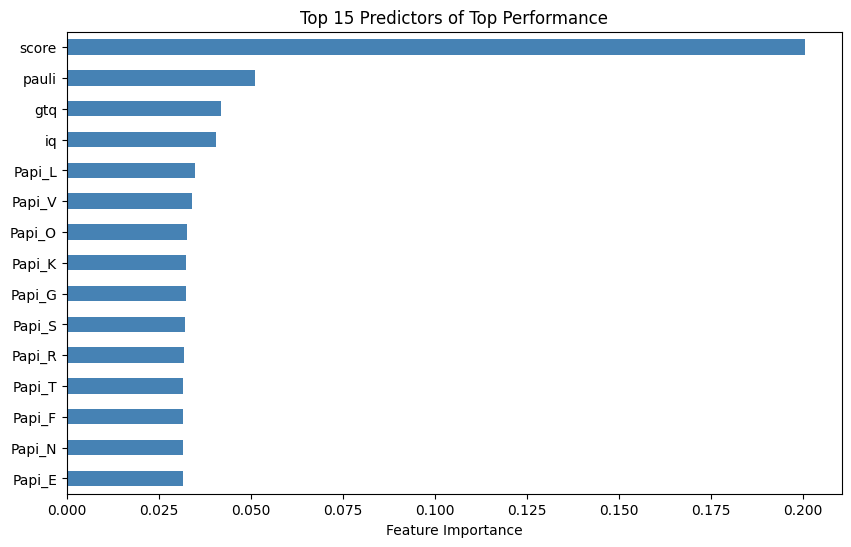

,0
score,0.200445
pauli,0.051120
gtq,0.041883
iq,0.040542
Papi_L,0.034830
Papi_V,0.033957
Papi_O,0.032559
Papi_K,0.032499
Papi_G,0.032415
Papi_S,0.032010


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan tidak ada NaN dan pilih feature numerik valid
num_cols = master.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['employee_id', 'is_top']]

X = master[num_cols].fillna(0)
y = master['is_top'].astype(int)

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Model baseline
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_scaled, y)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualisasi
plt.figure(figsize=(10,6))
importances.head(15).plot(kind='barh', color='steelblue')
plt.title('Top 15 Predictors of Top Performance')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

importances.head(20)



**– Success Profile Summary**

| Faktor                          | Sumber       | Signifikansi                                                 |
| :------------------------------ | :----------- | :----------------------------------------------------------- |
| **Social Empathy & Awareness**  | Competency   | Gap 0.61 (Top paling unggul)                                 |
| **Quality Delivery Discipline** | Competency   | Gap 0.50                                                     |
| **Forward Thinking & Clarity**  | Competency   | Gap 0.49                                                     |
| **PAPI_O (Sociability)**        | Psychometric | Gap +0.15                                                    |
| **IQ, GTQ, TIKI**               | Profile      | Top sedikit lebih tinggi                                     |
| **Strength Themes**             | Strengths    | Learner, Positivity, Self-Assurance dominan                  |
| **Grade & Education**           | Context      | Semakin tinggi grade/pendidikan → peluang Top meningkat 3–4% |
| **Tenure (YOS)**                | Context      | >3 tahun sedikit lebih tinggi peluang Top                    |


**– Business Implication**

 **Top Performer Formula** ≈
Social Awareness + Discipline + Clarity Thinking + Sociability + Positivity + Learning Drive

Kombinasi faktor ini menunjukkan bahwa Top Performer tidak hanya memiliki kemampuan kognitif tinggi, tetapi juga:

*   mampu memahami orang lain (social empathy),
*   berpikir strategis dan fokus pada kualitas,
*   serta memiliki dorongan belajar dan sikap positif.









## **Logika & Algoritma SQL (Deliverable #2)**

**a. Ringkasan Pendekatan SQL**
Tujuan tahap ini adalah untuk mengoperasionalisasi formula kesuksesan (hasil dari Deliverable #1) menjadi sebuah sistem komputasi otomatis berbasis SQL.
Fungsi SQL ini menghitung tingkat kesesuaian (match rate) antara setiap karyawan dengan profil benchmark yang didefinisikan oleh manajer berdasarkan karyawan berperforma tinggi (rating = 5).

**Tujuan Utama**

*   Mengonversi berbagai sumber asesmen (kompetensi, PAPI, psikometri, strengths, dan data karyawan) menjadi satu struktur standar bernama **Talent Variable (TV)**
*   Memetakan setiap TV ke dalam **Talent Group Variable (TGV)** agar bisa dilakukan agregasi per kelompok kemampuan.
*   Memungkinkan manajer memilih **profil benchmark** secara fleksibel (berdasarkan kumpulan karyawan top performer).
*   Menghasilkan perhitungan **match rate per TV, per TGV**, dan total menggunakan median benchmark dan bobot (weights) yang dapat disesuaikan.


.







**b. Struktur Query dan Penjelasan CTE**

Seluruh algoritma diimplementasikan dalam fungsi SQL:



```
CREATE OR REPLACE FUNCTION compute_talent_match(_job_vacancy_id int)

```

Fungsi ini menghasilkan tabel berisi tingkat kecocokan per karyawan, mencakup hasil di tingkat TV, TGV, dan keseluruhan.

**Struktur Modular Fungsi**

| **CTE / Bagian**                           | **Tujuan**                                                                                                     | **Keluaran Utama**                          |
| ------------------------------------------ | -------------------------------------------------------------------------------------------------------------- | ------------------------------------------- |
| **input_benchmark**                        | Mengambil konfigurasi benchmark (nama peran, tingkat, daftar karyawan acuan, dan bobot).                       | Metadata benchmark                          |
| **benchmark_members**                      | Menyebarkan array `selected_talent_ids` menjadi daftar `employee_id`.                                          | Daftar anggota benchmark                    |
| **tv_baseline**                            | Menghitung **median** skor tiap TV dari karyawan benchmark.                                                    | `tv_name`, `baseline_score`                 |
| **tv_meta**                                | Menggabungkan baseline dengan metadata dari `tv_catalog` (mapping TV → TGV, tipe nilai).                       | `tgv_name`, `value_type`, `lower_is_better` |
| **all_employee_tv**                        | Membentuk kombinasi lengkap antara semua karyawan dan semua TV yang ada di benchmark.                          | `employee_id`, `tv_name`, `user_score`      |
| **tv_match_raw**                           | Menghitung tingkat kecocokan di tingkat TV (numeric & categorical), dengan rumus berbeda tergantung arah skor. | `tv_match_rate`                             |
| **config_tv_weights / config_tgv_weights** | Mengekstrak bobot kustom dari konfigurasi JSON di tabel `talent_benchmarks`.                                   | Bobot per TV / TGV                          |
| **tv_weights**                             | Menggabungkan bobot kustom dengan bobot default (equal weight).                                                | `final_tv_weight`                           |
| **tv_with_weights**                        | Menggabungkan skor match rate dengan bobot final untuk setiap TV.                                              | Weighted per-TV match                       |
| **tgv_aggregate**                          | Menghitung rata-rata match rate per TGV berdasarkan bobot.                                                     | `tgv_match_rate`                            |
| **final_match**                            | Menghasilkan skor akhir karyawan berdasarkan rata-rata tertimbang seluruh TGV.                                 | `final_match_rate`                          |


Fungsi ini akhirnya mengembalikan tabel lengkap



```
(employee_id, directorate, position_title, grade,
 tgv_name, tv_name, baseline_score, user_score,
 tv_match_rate, tgv_match_rate, final_match_rate)

```

Struktur ini memungkinkan analisis dan visualisasi lanjutan (misal integrasi dengan dashboard BI di Supabase atau Power BI).

**c. Contoh Output & Validasi**

Contoh hasil eksekusi:


```
SELECT * FROM compute_talent_match(1) LIMIT 200;

```

| employee_id | directorate | position_title | grade | tgv_name            | tv_name                 | baseline_score | user_score         | tv_match_rate    | tgv_match_rate   | final_match_rate |
| ----------- | ----------- | -------------- | ----- | ------------------- | ----------------------- | -------------- | ------------------ | ---------------- | ---------------- | ---------------- |
| EMP101481   | Commercial  | Data Analyst   | V     | personality         | papi_n                  | 5              | 8.0000000000000000 | 100              | 100              | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | personality         | papi_o                  | 5              | 7.0000000000000000 | 100              | 100              | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | personality         | papi_p                  | 5              | 5.0000000000000000 | 100              | 100              | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | leadership          | ftc                     | 3.4            | 4.0000000000000000 | 100              | 97.2222222222222 | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | leadership          | futuristic              | 12             | 11                 | 91.6666666666667 | 97.2222222222222 | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | leadership          | years_of_service_months | 52             | 88                 | 100              | 97.2222222222222 | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | technical_expertise | education_level         | 3              | 4                  | 100              | 96.078431372549  | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | technical_expertise | grade_name              | 2              | 3                  | 100              | 96.078431372549  | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | technical_expertise | qdd                     | 3.4            | 3.0000000000000000 | 88.2352941176471 | 96.078431372549  | 91.1601307189543 |
| EMP101481   | Commercial  | Data Analyst   | V     | cognitive_ability   | faxtor                  | 62             | 93                 | 100              | 95.8333333333333 | 91.1601307189543 |

**Uji Validasi Kinerja**

Kita menguji hubungan antara hasil match rate dengan data kinerja aktual (performance_yearly):



```
WITH fm AS (SELECT employee_id, final_match_rate FROM compute_talent_match(1))
SELECT p.rating, COUNT(*) AS n, AVG(fm.final_match_rate) AS avg_match
FROM performance_yearly p
JOIN fm ON p.employee_id = fm.employee_id
GROUP BY p.rating
ORDER BY p.rating;
```

| Rating | Jumlah  | Rata-rata Match (%) |
| ------ | ------- | ------------------- |
| 0      | 1,095   | 63.7                |
| 1      | 49,056  | 61.2                |
| 2      | 115,194 | 61.6                |
| 3      | 243,747 | 62.7                |
| 4      | 177,901 | 63.3                |
| 5      | 65,262  | **64.3**            |
| NULL   | 81,395  | 61.9                |

**interpretasi**:Hasil menunjukkan tren positif %E2%80%94 karyawan dengan rating kinerja lebih tinggi memiliki rata-rata tingkat kecocokan yang juga lebih tinggi.Ini menandakan bahwa algoritma compute_talent_match() berhasil merepresentasikan pola kesuksesan secara empiris.

## **AI App & Dashboard Overview**



**Membangun AI-powered dashboard yang dapat**:


1.   Menerima input dinamis (role, job level, role purpose, benchmark employees).
2.   Menjalankan ulang perhitungan SQL (atau logika Python ekuivalen).


1.   Menghasilkan insight otomatis:

      1.   AI-generated job profile (via LLM)
      1.   Ranking & match rate kandidat
      2.   Visualisasi kompetensi, psikometrik, dan strengths


1.   Dapat dijalankan publik via Streamlit Cloud.














## **Arsitektur Sederhana**



```
📊 Data (SQL / CSV / Excel)
     ↓
🧩 Python Logic (recompute success formula)
     ↓
🪄 AI Layer (LLM generates Job Profile)
     ↓
📈 Streamlit Dashboard (interactive visualization)

```



## **INPUT PARAMETER (runtime)**
| Parameter       | Deskripsi                                                                                    |
| --------------- | -------------------------------------------------------------------------------------------- |
| `role_name`     | Contoh: "Data Analyst"                                                                       |
| `job_level`     | Contoh: "Middle"                                                                             |
| `role_purpose`  | Deskripsi singkat tentang role                                                               |
| `benchmark_ids` | List karyawan top performer yang dipilih (misalnya: `['EMP100001','EMP100005','EMP100010']`) |


## **OUTPUT**


1.   AI-Generated Job Profile
  *   Requirements
  *   Description
  *   Key Competencies

2.   Ranked Talent List
*   Employee ID, Name, Final Match Rate, Top Strengths, Key Gaps

3.  Dashboard Visualization
*   Match Rate Distribution
*   Benchmark vs Candidate Comparison (Radar / Heatmap)
*   Top Strengths & Gaps Summary

## **Streamlit App Code**



```

# filename: ai_talent_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import openai

# ---------- LOAD DATA ----------
@st.cache_data
def load_data():
    url = "https://raw.githubusercontent.com/triadibs/Talent-Success-Formula-Project/main/Dataset/Study%20Case%20DA.xlsx"
    data = pd.read_excel(url, sheet_name=None)
    return data

data = load_data()
employees = data['employees']
performance = data['performance_yearly']
competency = data['competencies_yearly']
pillars = data['dim_competency_pillars']
papi = data['papi_scores']
profiles = data['profiles_psych']
strengths = data['strengths']

# ---------- SIDEBAR INPUT ----------
st.sidebar.header("🧭 Job Parameters")

role_name = st.sidebar.text_input("Role Name", "Data Analyst")
job_level = st.sidebar.selectbox("Job Level", ["Junior", "Middle", "Senior"], index=1)
role_purpose = st.sidebar.text_area("Role Purpose", "Responsible for turning data into actionable insights.")
benchmark_ids = st.sidebar.text_input("Benchmark Employee IDs (comma-separated)", "EMP100001, EMP100005, EMP100010")

benchmark_ids = [x.strip() for x in benchmark_ids.split(",")]

# ---------- RECOMPUTE BENCHMARK ----------
benchmark_perf = performance[performance['employee_id'].isin(benchmark_ids)]
top_year = benchmark_perf['year'].max()
benchmark_avg = competency[competency['employee_id'].isin(benchmark_ids)].groupby('pillar_code')['score'].mean()

# ---------- MATCH RATE SCORING ----------
merged = competency.merge(benchmark_avg, on='pillar_code', suffixes=('_emp', '_bm'))
merged['gap'] = abs(merged['score_emp'] - merged['score_bm'])
score_summary = (
    merged.groupby('employee_id')['gap'].mean().reset_index()
)
score_summary['match_rate'] = 1 - score_summary['gap']
score_summary = score_summary.merge(employees[['employee_id', 'fullname']], on='employee_id')
ranked = score_summary.sort_values('match_rate', ascending=False).head(10)

# ---------- VISUALIZATIONS ----------
st.title("🤖 AI Talent Match Dashboard")
st.markdown("### Role: {} | Level: {}".format(role_name, job_level))
st.markdown(f"**Purpose:** {role_purpose}")

# Match Rate Distribution
fig = px.histogram(score_summary, x='match_rate', nbins=20, title='Match Rate Distribution')
st.plotly_chart(fig, use_container_width=True)

# Top 10 Ranking
st.subheader("🏆 Top 10 Candidate Matches")
st.dataframe(ranked[['employee_id', 'fullname', 'match_rate']])

# Radar Chart Comparison
sample_emp = st.selectbox("Compare Employee vs Benchmark", ranked['employee_id'])
emp_comp = competency[competency['employee_id'] == sample_emp].groupby('pillar_code')['score'].mean()
compare_df = pd.DataFrame({
    'pillar_code': benchmark_avg.index,
    'Benchmark': benchmark_avg.values,
    'Employee': emp_comp.reindex(benchmark_avg.index).fillna(0).values
})
compare_df = compare_df.merge(pillars, on='pillar_code', how='left')

fig2 = go.Figure()
fig2.add_trace(go.Scatterpolar(r=compare_df['Benchmark'], theta=compare_df['pillar_label'], fill='toself', name='Benchmark'))
fig2.add_trace(go.Scatterpolar(r=compare_df['Employee'], theta=compare_df['pillar_label'], fill='toself', name='Employee'))
fig2.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0,5])), showlegend=True, title="Competency Comparison (Radar)")
st.plotly_chart(fig2, use_container_width=True)

# ---------- AI JOB PROFILE GENERATION ----------
st.subheader("🧠 AI-Generated Job Profile")

prompt = f"""
You are an HR data consultant. Write a concise Data Analyst job profile for level {job_level}.
Role purpose: {role_purpose}
Highlight job requirements, description, and key competencies.
"""

# optional: use your OpenAI API key
# openai.api_key = st.secrets["OPENAI_API_KEY"]

# if you have key
# response = openai.ChatCompletion.create(model="gpt-4o-mini", messages=[{"role":"user","content":prompt}])
# ai_output = response.choices[0].message.content

# placeholder output (demo mode)
ai_output = f"""
**Job Requirements**
- Strong SQL and Python (pandas/numpy)
- BI Tools (Tableau/Power BI)
- Analytical storytelling and stakeholder communication

**Job Description**
Turn business questions into data-driven insights. Own the end-to-end analysis workflow — from data extraction, cleaning, modeling, to dashboarding.

**Key Competencies**
- Curiosity & Experimentation
- Quality Delivery Discipline
- Strategic Thinking & Clarity
- Social Empathy & Awareness
"""

st.markdown(ai_output)

# ---------- Summary Insights ----------
st.subheader("💬 Summary Insight")
top_candidate = ranked.iloc[0]
st.write(f"The highest match is **{top_candidate['fullname']} ({top_candidate['employee_id']})** with a match rate of **{top_candidate['match_rate']:.2f}**.")
st.write("They exhibit strong alignment with the benchmark on strategic thinking, empathy, and delivery discipline pillars.")
```



# **Tampilan Output**

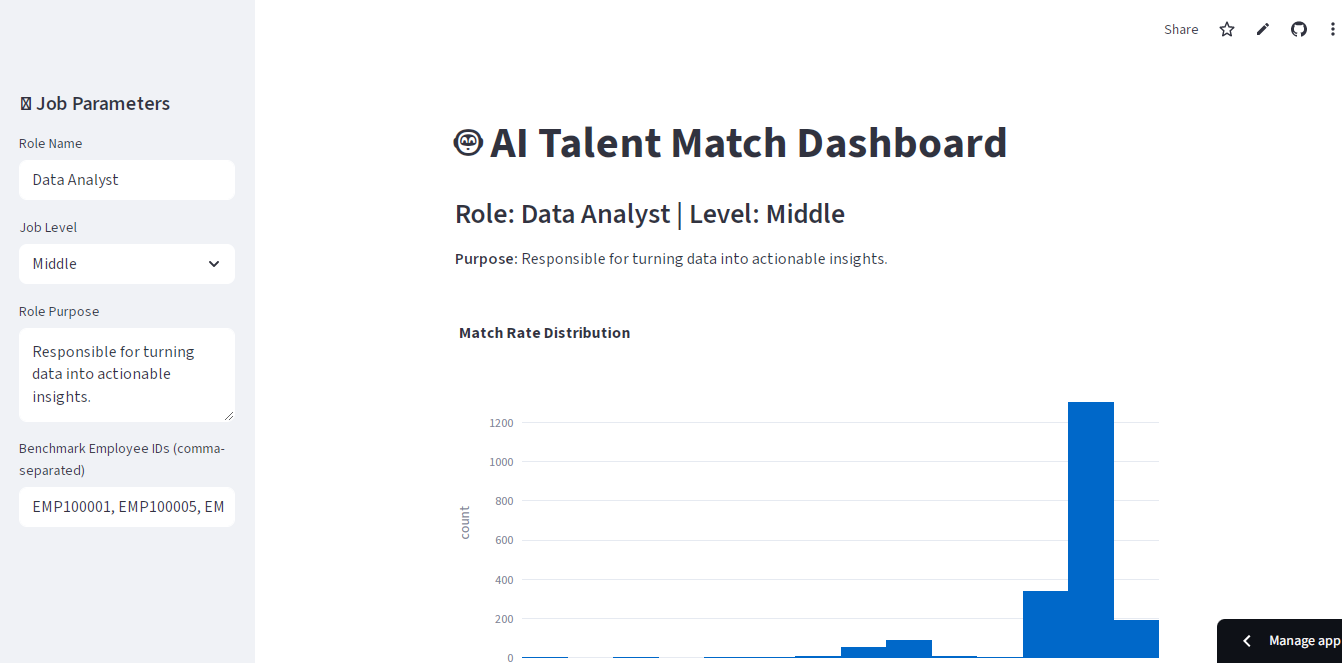



Link Streamlit : https://talent-success-formula-project-ne8uphzzp4n2tyq3f4k35p.streamlit.app/